In [ ]:
TEAM_ID - 12
SEM - 5
DIV - 'A'
DEPT - COMPUTER SCIENCE

TITLE_ID - '5DMACP12'

'PROBLEM STATEMENT' = GENERATION OF 3D MODEL FROM SINGLE IMAGE

DEBABRATA MAITY - 01FE18BCS068
DARSHAN PATGAR  - 01FE18BCS066
DEEPAK SHINDE   - 01FE18BCS069
DEEPTI BANDI    - 01FE18BCS071


In [ ]:
import cv2
import numpy as np

In [ ]:
#segmenting image using opencv
img = cv2.imread('58211301130001.jpg') #read image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #convert to gray scale
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #using difft types of thresholding
cv2.imshow('depth', thresh) 
cv2.waitKey(0)  
  
#closing all open windows  
cv2.destroyAllWindows()  


In [ ]:
#using watershed algorithm
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)


# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
cv2.imshow('man1', unknown)
cv2.waitKey(0)  
  
#closing all open windows  
cv2.destroyAllWindows()  

In [ ]:
cv2.imwrite("temple_new_one.png",unknown)

True

In [ ]:
#using open3d library for creating point cloud 
import open3d as o3d 

In [ ]:
print("Read dataset images")
color_raw = o3d.io.read_image('58211301130001.jpg')
depth_raw = o3d.io.read_image('temple_new_one.png')
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw) #geometry of both images i.e color, depth
print(rgbd_image)

Read dataset images
RGBDImage of size 
Color image : 4160x2080, with 1 channels.
Depth image : 4160x2080, with 1 channels.
Use numpy.asarray to access buffer data.


In [ ]:
import matplotlib.pyplot as plt

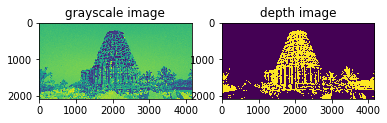

In [ ]:
#plotting using matplotlib
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()

POINT CLOUD GENERATION


In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) #creating point cloud from image
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

PointCloud with 1728124 points.

In [ ]:
#voxelization and viewing point cloud
print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])



Downsample the point cloud with a voxel of 0.05


Write the output file


In [ ]:
o3d.io.write_point_cloud("temple212.ply", downpcd)

True

In [ ]:
#calculating point cloud points
import numpy as np
print(np.asarray(downpcd.points))


[[-0.21428571  0.07380952 -1.25      ]
 [-0.17051428  0.02557714 -1.11899996]
 [ 0.70098288 -0.70668193 -1.49600005]
 ...
 [ 0.6838     -0.73840001 -1.36500001]
 [ 0.6864     -0.73840001 -1.36500001]
 [ 0.689      -0.73840001 -1.36500001]]


In [ ]:
#using kdtree method to make compact point cloud
downpcd = pcd.voxel_down_sample(voxel_size=0.00001)

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([downpcd])

print("Print a normal vector of the 0th point")
print(downpcd.normals[0])
print("Print the normal vectors of the first 10 points")
print(np.asarray(downpcd.normals)[:10, :])
print("")

Recompute the normal of the downsampled point cloud
Print a normal vector of the 0th point
[ 9.75572929e-13 -9.36589618e-13  1.00000000e+00]
Print the normal vectors of the first 10 points
[[ 9.75572929e-13 -9.36589618e-13  1.00000000e+00]
 [-3.71603186e-13  2.23968957e-13  1.00000000e+00]
 [-2.89845306e-12 -2.40457974e-13 -1.00000000e+00]
 [-8.98348740e-13 -4.89535744e-13  1.00000000e+00]
 [ 2.52392320e-12 -4.59949301e-13 -1.00000000e+00]
 [-8.48496362e-13 -5.32894745e-14  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-1.15059681e-12  3.80642093e-13 -1.00000000e+00]
 [ 1.09577473e-12 -9.03269613e-13  1.00000000e+00]
 [ 1.76558456e-12  3.22740301e-13  1.00000000e+00]]



In [ ]:
#visualization 
def custom_draw_geometry_with_custom_fov(downpcd, fov_step):
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(downpcd)
    ctr = vis.get_view_control()
    print("Field of view (before changing) %.2f" % ctr.get_field_of_view())
    ctr.change_field_of_view(step=fov_step)
    print("Field of view (after changing) %.2f" % ctr.get_field_of_view())
    vis.run()
    vis.destroy_window()

In [ ]:
custom_draw_geometry_with_custom_fov(downpcd, 90.0)

Field of view (before changing) 60.00
Field of view (after changing) 90.00


In [ ]:
custom_draw_geometry_with_custom_fov(downpcd, -90.0)

Field of view (before changing) 60.00
Field of view (after changing) 5.00


In [ ]:
#for rotation view 
def rotate_view(vis):
        ctr = vis.get_view_control()
        ctr.rotate(10.0, 0.0)
        return False
o3d.visualization.draw_geometries_with_animation_callback([downpcd],rotate_view)

In [ ]:
alpha = 0
print(f"alpha={alpha:.3f}")
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(downpcd)
o3d.visualization.draw_geometries([downpcd,tetra_mesh], mesh_show_back_face=True)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(downpcd, alpha, tetra_mesh)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([downmesh], mesh_show_back_face=True)

In [ ]:
def load_point_clouds(voxel_size=0.0):
    pcds = []
    for i in range(3):
        pcd = o3d.io.read_point_cloud("war.ply".format(i))
        pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds.append(pcd_down)
    return pcds

In [ ]:
voxel_size = 0.01
pcds_down = load_point_clouds(voxel_size)
o3d.visualization.draw_geometries(pcds_down)

MESH CONSTRUCTION METHODS


In [ ]:
1) Ball pivot method

In [ ]:
pcd = o3d.io.read_point_cloud("stump11_mesh.ply")

In [ ]:
print(pcd.has_normals())

True


In [ ]:
print(pcd.normals)

std::vector<Eigen::Vector3d> with 139509 elements.
Use numpy.asarray() to access data.


In [ ]:
print(pcd.normals[0])

[-0.5171181   0.59695286  0.61338092]


In [ ]:
import numpy as np

In [ ]:
#radius determination
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 2 * avg_dist

In [ ]:
#computing the mehs
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [ ]:
#decimating the mesh
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

TriangleMesh with 136682 points and 99877 triangles.

In [ ]:
mesh = dec_mesh.filter_sharpen(number_of_iterations=1, strength=1)

In [ ]:
o3d.visualization.draw_geometries([mesh])

POISSION RECONSTRUCTION MESH METHOD

In [ ]:
2. Poisiion reconstruction

In [ ]:
#computing the mesh
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [ ]:
#cropping
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
#export
o3d.io.write_triangle_mesh("stump11_mesh.ply", dec_mesh)
o3d.io.write_triangle_mesh("stump12_mesh.ply", p_mesh_crop)

True

In [ ]:
#function creation
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
#execution of function
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], "stump11_mesh.ply", r'C:\Users\Darshan LP\Desktop')

generation of 100 LoD successful


In [ ]:
#execution of function
my_lods2 = lod_mesh_export(bpa_mesh, [8000,800,300], "stump11_mesh.ply", r'C:\Users\Darshan LP\Desktop')

generation of 300 LoD successful


In [ ]:
dam = o3d.io.read_point_cloud("stump11_mesh.ply")

In [ ]:
o3d.visualization.draw_geometries([dam])

TRIMESH MESH CONSTRUCTION


In [ ]:
3. Trimesh method for reconstruction

In [ ]:
import numpy as np
import trimesh

In [ ]:
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0]],
                       faces=[[0, 1, 2]])

In [ ]:
mesh = trimesh.Trimesh(vertices=[[0, 0, 0], [0, 0, 1], [0, 1, 0]],
                       faces=[[0, 1, 2]],
                       process=False)


In [ ]:
# load a file by name or from a buffer
mesh = trimesh.load_mesh('stump11_mesh.ply')
# to keep the raw data intact, disable any automatic processing
#mesh = trimesh.load_mesh('../models/featuretype.STL', process=False)

In [ ]:
mesh.is_watertight

False

In [ ]:
mesh.euler_number

-774

In [ ]:
np.divide(mesh.volume, mesh.convex_hull.volume)

0.012845122446881203

In [ ]:
mesh.vertices -= mesh.center_mass


In [ ]:
# what's the moment of inertia for the mesh?
mesh.moment_inertia

array([[-2.22052234e+08,  1.06425479e+00,  3.28846659e+02],
       [ 1.06425479e+00, -2.21523035e+08, -1.08244934e+07],
       [ 3.28846659e+02, -1.08244934e+07, -5.29199534e+05]])

In [ ]:
# if there are multiple bodies in the mesh we can split the mesh by
# connected components of face adjacency
# since this example mesh is a single watertight body we get a list of one mesh
mesh.split()

array([<trimesh.Trimesh(vertices.shape=(6, 3), faces.shape=(8, 3))>,
       <trimesh.Trimesh(vertices.shape=(5, 3), faces.shape=(6, 3))>,
       <trimesh.Trimesh(vertices.shape=(5, 3), faces.shape=(6, 3))>,
       <trimesh.Trimesh(vertices.shape=(5, 3), faces.shape=(6, 3))>,
       <trimesh.Trimesh(vertices.shape=(5, 3), faces.shape=(6, 3))>],
      dtype=object)

In [ ]:
print(mesh.visual.kind)

vertex


In [ ]:
# preview mesh in a pyglet window from a terminal, or inline in a notebook
mesh.show()

ICP REGISTRATION FOR THE FULL VIEW OF MODEL

In [ ]:
#Global ICP registration

In [ ]:

import numpy as np
import copy

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [ ]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [ ]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    source = o3d.io.read_point_cloud("chair2.pcd")
    target = o3d.io.read_point_cloud("chair6.pcd")
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [ ]:
voxel_size = 0.05  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)

:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [ ]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        4, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 480))
    return result

In [ ]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=6.528716e-01, inlier_rmse=3.191591e-02, and correspondence_set size of 773
Access transformation to get result.


In [ ]:
print("3-2. Estimate normal.")
source.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 30))
target.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius = 0.1, max_nn = 30))

3-2. Estimate normal.


In [ ]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.001
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [ ]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
new = draw_registration_result(source, target, result_icp.transformation)

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.000.
RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
